In [1]:
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim

In [2]:
class SMnet(nn.Module):
    def __init__(self):
        super(SMnet, self).__init__()
        self.linear_start1 = nn.Linear(20,256)#20,128
        self.linear_start2 = nn.Linear(256,512)#128,256
        #self.linear_start1.cuda()
        #self.linear_start2.cuda()
        self.lstm = nn.LSTM(
            input_size=512, 
            hidden_size=1024, 
            num_layers=3,
            batch_first=True)#256,512,3
        
       # self.lstm.cuda()
        self.linear1 = nn.Linear(1024, 512)#512,256
        self.linear2 = nn.Linear(512, 3)#256,3
        #self.linear1.cuda()
        #self.linear2.cuda()
        
    def forward(self, robot_sensors):
        ls_out1 = self.linear_start1(robot_sensors)
        ls_out2 = self.linear_start2(ls_out1)
        lstm_out, (h_n, h_c) = self.lstm(ls_out2)
        l_out1 = self.linear1(lstm_out)
        l_out2 = self.linear2(l_out1)

        return l_out2
        

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt

data_x= pd.read_csv('joints_tobar.txt',delimiter=" ",header=None)
data_y= pd.read_csv('ground_truth.txt',delimiter=" ",header=None)
feat=data_x.as_matrix()
gtruth=data_y.as_matrix()

print('{0:2d} datos de entrada con tamaño {1:2d}'.format(len(feat),len(feat[0])))
print('{0:2d} datos de salida con tamaño {1:2d}'.format(len(gtruth),len(gtruth[0])))
y=[]
x=[]
time=[]
#print(ground_t)
#Extraer x,y,z
for i in range(0,len(feat)):
    xi=[]
    for j in range(1,len(feat[0])):
        xi.append(feat[i][j])
    x.append(xi)
    time.append(feat[i][0])
    #if i%10000==0:
        #print(xi)
        
for i in range(0,len(gtruth)):
    pos=[]
    pos.append(gtruth[i][1])
    pos.append(gtruth[i][2])
    pos.append(gtruth[i][3])
    y.append(pos)
    #if i%10000==0:
        #print(pos)
        
print('{0:2d} datos de entrada con tamaño {1:2d}'.format(len(x),len(x[0])))
print('{0:2d} datos de salida con tamaño {1:2d}'.format(len(y),len(y[0])))

46874 datos de entrada con tamaño 21
46874 datos de salida con tamaño  8
46874 datos de entrada con tamaño 20
46874 datos de salida con tamaño  3


In [4]:
x_train= x[:30000]
y_train= y[:30000]
t_train=time[:30000]
x_val = x[30000:]
y_val = y[30000:]
t_val=time[30000:]
print('tamaño características de entrenamiento: {0:2d}'.format(len(x_train)))
print('tamaño características de validacion: {0:2d}'.format(len(y_val)))
print('--------------------------------------------------------------------')
print('tamaño groundtruth de entrenamiento: {0:2d}'.format(len(x_train)))
print('tamaño groundtruth de validacion: {0:2d}'.format(len(y_val)))

tamaño características de entrenamiento: 30000
tamaño características de validacion: 16874
--------------------------------------------------------------------
tamaño groundtruth de entrenamiento: 30000
tamaño groundtruth de validacion: 16874


In [5]:
import sklearn as skl
std_scale=skl.preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_val = std_scale.transform(x_val)
std_scale=skl.preprocessing.StandardScaler().fit(y)
y_train = std_scale.transform(y_train)
y_val = std_scale.transform(y_val)

In [6]:
#from sklearn.feature_selection import SelectKBest, mutual_info_classif
#sel = SelectKBest(score_func=mutual_info_classif,k=15).fit(x_train, y_train)
#x_train= sel.transform(x_train)
#x_val=sel.transform(x_val)

In [7]:
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)
input= torch.from_numpy(np.array(x_train))
target = torch.from_numpy(np.array(y_train))
#target = target.unsqueeze(0)
test_input = torch.from_numpy(np.array(x_val))
test_target = torch.from_numpy(np.array(y_val))
# build the model
sm = SMnet()
sm.double()
criterion = nn.L1Loss(size_average=False)
# create your optimizer
optimizer = optim.SGD(sm.parameters(), lr=0.001, momentum=0.9)

C:\Users\Giopa\Anaconda3\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [8]:
# in your training loop:
for i in range(200):
    optimizer.zero_grad()   # zero the gradient buffers
    batch = input[i:i+5,:]
    batch = batch.unsqueeze(0)
    print(batch.size())
    batch_target = target[i:i+5,:]
    batch_target = batch_target.unsqueeze(0)
    output = sm(batch)
    loss = criterion(output, batch_target)
    print("loss: {}".format(loss))
    loss.backward()
    optimizer.step() # Does the update

torch.Size([1, 5, 20])
loss: 12.596076257262444
torch.Size([1, 5, 20])
loss: 12.456167335031505
torch.Size([1, 5, 20])
loss: 12.203789490410584
torch.Size([1, 5, 20])
loss: 11.845941543484209
torch.Size([1, 5, 20])
loss: 11.400626346994404
torch.Size([1, 5, 20])
loss: 10.8678596770606
torch.Size([1, 5, 20])
loss: 10.268412857363348
torch.Size([1, 5, 20])
loss: 9.61203086353092
torch.Size([1, 5, 20])
loss: 8.89020766566954
torch.Size([1, 5, 20])
loss: 8.115959610503841
torch.Size([1, 5, 20])
loss: 7.862434818399466
torch.Size([1, 5, 20])
loss: 7.92541096348107
torch.Size([1, 5, 20])
loss: 7.835166706056196
torch.Size([1, 5, 20])
loss: 7.634695389359645
torch.Size([1, 5, 20])
loss: 7.3093123747127935
torch.Size([1, 5, 20])
loss: 6.888870831710319
torch.Size([1, 5, 20])
loss: 6.372237788162905
torch.Size([1, 5, 20])
loss: 5.793582491633737
torch.Size([1, 5, 20])
loss: 5.134439644255835
torch.Size([1, 5, 20])
loss: 4.421844476117248
torch.Size([1, 5, 20])
loss: 4.222682696221135
torch.Size

torch.Size([1, 5, 20])
loss: 0.49624307888636376
torch.Size([1, 5, 20])
loss: 0.5747595554136182
torch.Size([1, 5, 20])
loss: 0.7129327415743169
torch.Size([1, 5, 20])
loss: 0.7162942151944436
torch.Size([1, 5, 20])
loss: 0.6358092059542584
torch.Size([1, 5, 20])
loss: 0.46180314583538357
torch.Size([1, 5, 20])
loss: 0.3028536299615978
torch.Size([1, 5, 20])
loss: 0.11209568403640019
torch.Size([1, 5, 20])
loss: 0.2199837493708271
torch.Size([1, 5, 20])
loss: 0.4439180375582109
torch.Size([1, 5, 20])
loss: 0.5600680213594825
torch.Size([1, 5, 20])
loss: 0.6231268957646372
torch.Size([1, 5, 20])
loss: 0.6565813367149806
torch.Size([1, 5, 20])
loss: 0.5941368968648886
torch.Size([1, 5, 20])
loss: 0.528928069500578
torch.Size([1, 5, 20])
loss: 0.45321214474631855
torch.Size([1, 5, 20])
loss: 0.256589048069385
torch.Size([1, 5, 20])
loss: 0.1402958444935009
torch.Size([1, 5, 20])
loss: 0.28973996612341796
torch.Size([1, 5, 20])
loss: 0.282593139973384
torch.Size([1, 5, 20])
loss: 0.4275229

In [9]:
sm.eval()

SMnet(
  (linear_start1): Linear(in_features=20, out_features=256, bias=True)
  (linear_start2): Linear(in_features=256, out_features=512, bias=True)
  (lstm): LSTM(512, 1024, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=1024, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=3, bias=True)
)

In [10]:
print(test_input.size())

torch.Size([16874, 20])


In [11]:
testiing = sm(test_input[:4,:].unsqueeze(0)) 

In [12]:
print(testiing.size())

torch.Size([1, 4, 3])


In [13]:
print(testiing)

tensor([[[ 0.2746,  0.3289, -1.7897],
         [ 0.2751,  0.3274, -1.7898],
         [ 0.2750,  0.3263, -1.7870],
         [ 0.2748,  0.3256, -1.7837]]],
       dtype=torch.float64, grad_fn=<ThAddBackward>)


In [14]:
print(test_target[:4])

tensor([[-0.1343,  0.3964, -0.5056],
        [-0.1343,  0.3964, -0.5056],
        [-0.1343,  0.3964, -0.5056],
        [-0.1343,  0.3964, -0.5056]], dtype=torch.float64)


In [15]:
sm = SMnet()
sm.double()
criterion = nn.L1Loss(size_average=False)
# create your optimizer
optimizer = optim.SGD(sm.parameters(), lr=0.001, momentum=0.9)
for i in range(200):
    optimizer.zero_grad()   # zero the gradient buffers
    batch = input[i:i+5,:]
    batch = batch.unsqueeze(0)
    print(batch.size())
    batch_target = target[i:i+5,:]
    batch_target = batch_target.unsqueeze(0)
    output = sm(batch)
    loss = criterion(output, batch_target)
    print("loss: {}".format(loss))
    loss.backward()
    optimizer.step() # Does the update

C:\Users\Giopa\Anaconda3\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


torch.Size([1, 5, 20])
loss: 12.825166994700329
torch.Size([1, 5, 20])
loss: 12.68261178161315
torch.Size([1, 5, 20])
loss: 12.425952681749083
torch.Size([1, 5, 20])
loss: 12.061959480616022
torch.Size([1, 5, 20])
loss: 11.608939171662861
torch.Size([1, 5, 20])
loss: 11.06726623524859
torch.Size([1, 5, 20])
loss: 10.455954207194113
torch.Size([1, 5, 20])
loss: 9.787925347980948
torch.Size([1, 5, 20])
loss: 9.053689397108739
torch.Size([1, 5, 20])
loss: 8.421707615241532
torch.Size([1, 5, 20])
loss: 8.043784769845704
torch.Size([1, 5, 20])
loss: 7.854323581263662
torch.Size([1, 5, 20])
loss: 7.802396430857395
torch.Size([1, 5, 20])
loss: 7.639437157009439
torch.Size([1, 5, 20])
loss: 7.349555842934505
torch.Size([1, 5, 20])
loss: 6.962229999274251
torch.Size([1, 5, 20])
loss: 6.475962351311424
torch.Size([1, 5, 20])
loss: 5.926349530235745
torch.Size([1, 5, 20])
loss: 5.296207399495866
torch.Size([1, 5, 20])
loss: 4.909938981034548
torch.Size([1, 5, 20])
loss: 4.468364721306327
torch.Si

torch.Size([1, 5, 20])
loss: 0.44590888811664386
torch.Size([1, 5, 20])
loss: 0.39636707947285166
torch.Size([1, 5, 20])
loss: 0.31257864589001844
torch.Size([1, 5, 20])
loss: 0.22505099765774633
torch.Size([1, 5, 20])
loss: 0.08741232042586339
torch.Size([1, 5, 20])
loss: 0.15056172008300656
torch.Size([1, 5, 20])
loss: 0.24937575801459072
torch.Size([1, 5, 20])
loss: 0.3077704546982948
torch.Size([1, 5, 20])
loss: 0.3243017101481723
torch.Size([1, 5, 20])
loss: 0.31059432989177266
torch.Size([1, 5, 20])
loss: 0.25903170352255867
torch.Size([1, 5, 20])
loss: 0.13873189323732288
torch.Size([1, 5, 20])
loss: 0.08538921333377303
torch.Size([1, 5, 20])
loss: 0.1604978764480563
torch.Size([1, 5, 20])
loss: 0.19110065857267933
torch.Size([1, 5, 20])
loss: 0.17788375723514843
torch.Size([1, 5, 20])
loss: 0.16828691415183444
torch.Size([1, 5, 20])
loss: 0.10812394879364162
torch.Size([1, 5, 20])
loss: 0.15810002837344944
torch.Size([1, 5, 20])
loss: 0.296978889043393
torch.Size([1, 5, 20])
lo

In [16]:
Z = sm(test_input.unsqueeze(0))

In [17]:
print(Z)

tensor([[[ 0.2734,  0.3151, -1.7960],
         [ 0.2732,  0.3143, -1.7949],
         [ 0.2729,  0.3136, -1.7921],
         ...,
         [ 0.2688,  0.3020, -1.7122],
         [ 0.2679,  0.3025, -1.7126],
         [ 0.2678,  0.3029, -1.7131]]],
       dtype=torch.float64, grad_fn=<ThAddBackward>)


In [18]:
Z=Z.view(-1,3)
print(Z)

tensor([[ 0.2734,  0.3151, -1.7960],
        [ 0.2732,  0.3143, -1.7949],
        [ 0.2729,  0.3136, -1.7921],
        ...,
        [ 0.2688,  0.3020, -1.7122],
        [ 0.2679,  0.3025, -1.7126],
        [ 0.2678,  0.3029, -1.7131]],
       dtype=torch.float64, grad_fn=<ViewBackward>)


In [19]:
    x_pred=[]
    x_true=[]
    y_pred=[]
    y_true=[]
    z_pred=[]
    z_true=[]
    t=list(range(0, 16873))
    for k in range(0,len(y_val)):
        x_pred.append(Z[k][0].item())
        x_true.append(y_val[k][0].item())
        y_pred.append(Z[k][1])
        y_true.append(y_val[k][1])
        z_pred.append(Z[k][2])
        z_true.append(y_val[k][2])

x RMSE: 0.9757497627695024
y RMSE: 0.8132838691615462
z RMSE: 2.859513298202598
-----------------------------------
x RMSE: 3.3540376918274557


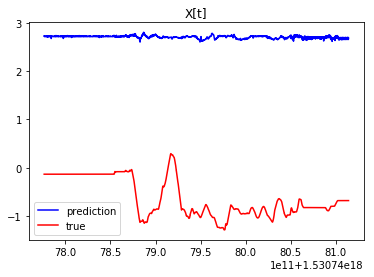

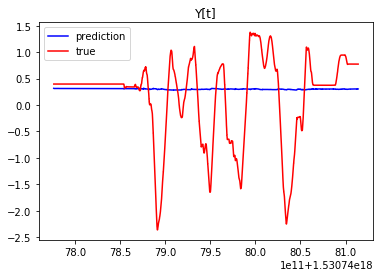

NameError: name 'z_pred2' is not defined

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(x_true, x_pred))
print('x RMSE: {}'.format(rms)) # Sin normalizar: 2.01914| Con normalizar: 2.0322

rms = sqrt(mean_squared_error(y_true, y_pred))
print('y RMSE: {}'.format(rms)) # Sin normalizar: 0.6174| Con normalizar: 0.6184

rms = sqrt(mean_squared_error(z_true, z_pred))
print('z RMSE: {}'.format(rms)) # Sin normalizar: 0.1204| Con normalizar: 0.1091

print('-----------------------------------')

#print(x_pred)
x_pred2 = [x * 10 for x in x_pred]
rms = sqrt(mean_squared_error(x_true, x_pred2))
print('x RMSE: {}'.format(rms)) # Sin normalizar: 2.01914| Con normalizar: 2.0322

#y_pred2 = [y * 10 for x in y_pred]
#rms = sqrt(mean_squared_error(y_true, y_pred2))
#print('y RMSE: {}'.format(rms)) # Sin normalizar: 2.01914| Con normalizar: 2.0322

#z_pred2 = [z * 10 for x in z_pred]
#rms = sqrt(mean_squared_error(z_true, z_pred2))
#print('z RMSE: {}'.format(rms)) # Sin normalizar: 2.01914| Con normalizar: 2.0322





import matplotlib.pyplot as plt

plt.plot(t_val,x_pred2,'b')
plt.plot(t_val,x_true,'r')
plt.title('X[t]')
plt.legend(['prediction','true'])
plt.show()

plt.plot(t_val,y_pred,'b')
plt.plot(t_val,y_true,'r')
plt.title('Y[t]')
plt.legend(['prediction','true'])
plt.show()

plt.plot(t_val,z_pred2,'b')
plt.plot(t_val,z_true,'r')
plt.title('Z[t]')
plt.legend(['prediction','true'])
plt.show()